<a href="https://colab.research.google.com/github/daniel-hain/bibliometrics_EIST_2021/blob/master/python/BERTopic_EIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTopic EIST 

* First tryout on EIST topic modelling using BERT an reprentation learning.


## Setup

In [1]:
# Weird monkey patch
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# When using openai (doesnt work right now)
!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.5 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
# Change directory

In [3]:
# Installing BERTopic
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
    

## Data

* Title + Abstracts of all EIST articles up to 02.2023

In [4]:
import os
import pandas as pd
docs = pd.read_csv("https://raw.githubusercontent.com/daniel-hain/bibliometrics_EIST_2021/master/data/data_text.csv")
docs.head()

,UT,PY,text
0,2-S2.0-79957989573,2011,the multi-level perspective on sustainability ...
1,2-S2.0-85060849107,2019,an agenda for sustainability transitions resea...
2,2-S2.0-85009887792,2017,putting the sharing economy into perspective. ...
3,2-S2.0-84941180282,2015,the geography of sustainability transitions: r...
4,2-S2.0-79957999094,2011,engaging with the politics of sustainability t...


# **Topic Modeling**



## Training



In [5]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration

from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline

from hdbscan import HDBSCAN
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# Own stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = ["study", "studies", "paper", "insight", "insights", "research", "literature", "framework", "frameworks","rights","reserved" , "study", "studies", "these", "this", "paper", "result", "model", "approach", "article", "author", "method", "understand", "focus", "examine", "aim", "argue", "identify",
          "increase", "datum", "potential", "explore", "include", "issue", "propose", "address", "apply", "require", "analyse", "relate", "finding",
          "analyze", "discuss", "contribute", "publish", "involve", "draw", "lead", "exist", "set", "reduce", "create", "form", "explain", "play",
          "affect", "regard", "associate", "establish", "follow", "conclude", "define", "strong", "attempt", "finally", "elsevier", "offer",
          "taylor", "francis", "copyright", "springer", "wiley", "emerald", "copyright", "b.v"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Some hyperparameters
umap_n_neighbors = 5
umap_n_components = 10
umap_min_dist = 0

hdbscan_min_cluster_size = 10
hdbscan_min_samples = hdbscan_min_cluster_size

# EMBEDDING MODEL:
embedding_model = "allenai-specter"

# DIMENSIONALITY REDUCTION
umap_model = UMAP(n_neighbors=umap_n_neighbors, 
                  n_components=umap_n_components, 
                  min_dist=umap_min_dist, 
                  metric='cosine', 
                  random_state=1337)

# CLUSTERING: resuce min_cluster_size and min_samples
hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=hdbscan_min_samples)

# VECTORIZER: custom vectorizer to get rid of stopwords
vectorizer_model = CountVectorizer(stop_words=stpwrd,
                                   min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,
                                     reduce_frequent_words=True)

In [8]:
import openai
from bertopic.representation import OpenAI

from getpass import getpass # get from: https://docs.google.com/spreadsheets/d/1Zjy7IFRqowBsB1W7vPRQRYcqANOo82LJEvNR22iAsA8/edit#gid=0
#openai.api_key = getpass('Enter OpenAi secret value: ')

In [9]:
## REPRESENTATION MODEL: 
representation_model = MaximalMarginalRelevance(diversity=0.7)
#representation_model = KeyBERTInspired()
#representation_model = OpenAI()

In [10]:
# BEWRTopic: specify all custom models and n_grams
topic_model = BERTopic(nr_topics="auto",
                       language="english", 
                       calculate_probabilities=True,
                       verbose=True, 
                       n_gram_range=(1, 3),
                       #
                       embedding_model=embedding_model, 
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model)

In [11]:
topics, probs = topic_model.fit_transform(docs.loc[:,'text'])

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2023-03-15 11:02:39,327 - BERTopic - Transformed documents to Embeddings
2023-03-15 11:02:47,749 - BERTopic - Reduced dimensionality
2023-03-15 11:02:47,801 - BERTopic - Clustered reduced embeddings
2023-03-15 11:02:49,315 - BERTopic - Reduced number of topics from 14 to 14


## Extracting Topics
* After fitting our model, we can start by looking at the results. 
* Typically, we look at the most frequent topics first as they best represent the collection of documents. 
* -1 refers to all outliers and should typically be ignored. 

In [12]:
freq = topic_model.get_topic_info(); freq.head(50)

,Topic,Count,Name
0,-1,127,-1_institutional_work_financial_sector
1,0,208,0_field_governance_change_attention
2,1,70,1_political_power_european_actors
3,2,69,2_business_learning_firms_niche
4,3,27,3_regime_public_knowledge_attention
5,4,24,4_innovation_knowledge_barriers_within
6,5,24,5_technological_business_sectors_firms
7,6,18,6_financial_economy_efficiency_carbon
8,7,17,7_markets_network_learning_government
9,8,16,8_impacts_risks_low_emissions


## Attributes

* There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

# **Visualization**
* There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. 
* Topic modeling is, to a certain extent, quite subjective. * Visualizations help understand the topics that were created. 

## General topic relation

In [13]:
topic_model.visualize_topics()

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [14]:
topic_model.visualize_barchart(top_n_topics=50, n_words = 10)

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

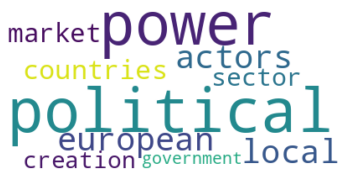

In [16]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [17]:
# Representative docs
rep_doc = topic_model.get_representative_docs()
rep_doc = pd.DataFrame(rep_doc)
rep_doc.T

,0,1,2
-1,beyond the north-south divide: the political e...,framing low-carbon pathways: a discursive anal...,closing the green finance gap – a systems pers...
0,exploring the governance and politics of trans...,the changing landscape of deep transitions: so...,households in sustainability transitions: a sy...
1,mere deployment of renewables or industry form...,explaining inclusivity in energy transitions: ...,trust gaps in energy transitions: japan's nati...
2,user-led innovation in civic energy communitie...,the role of lock-in mechanisms in transition p...,understanding the drivers of fleet emission re...
3,sustainability transitions in the agri-food se...,beyond food for thought – directing sustainabi...,analysing the role of consumers within technol...
4,anchoring of innovations: assessing dutch effo...,power from above? assessing actor-related barr...,zero carbon homes in the uk? analysing the co-...
5,influences of technological and sectoral conte...,china's role in the next phase of the energy t...,the institutional evolution process of the glo...
6,sustainability transition and economic growth ...,"macroeconomics, financial crisis and the envir...",climate change and economic growth enigma: an ...
7,conceptualizing market formation for transform...,using lead market factors to assess the potent...,understanding the limits to forming policy-dri...
8,modelling energy transitions for climate targe...,incorporating social mechanisms in energy deca...,evaluating the global impact of low-carbon ene...


In [18]:
embeddings = topic_model.embedding_model.embed_documents(docs.loc[:,'text'])
pd.DataFrame(embeddings).to_csv('embeddings_specter.csv')

In [19]:
topic_model.visualize_documents(docs.loc[:,'text'], embeddings=embeddings)

## Visualize Topic Hierarchy

* The topics that were created can be hierarchically reduced. 
* In order to understand the potential hierarchical structure of the topics, we can create clusters and visualize how they relate to one another. 
* This might also help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [20]:
# Calculate Hirarchy
hierarchical_topics = topic_model.hierarchical_topics(docs.loc[:,'text'])

100%|██████████| 12/12 [00:00<00:00, 12.30it/s]


In [21]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [22]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs.loc[:,'text'], hierarchical_topics, embeddings=embeddings)

## Topics over time

In [23]:
# Calculate topics over time
topics_over_time = topic_model.topics_over_time(docs.loc[:,'text'],
                                                docs.loc[:,'PY'])

13it [00:06,  1.90it/s]


In [24]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [25]:
topic_model.visualize_heatmap(n_clusters=5, width=1000, height=1000)

# Optimal: Finetune topics

Only do if you think something should be changes

In [26]:
# VECTORIZER: custom vectorizer to get rid of stopwords
#vectorizer_model = CountVectorizer(stop_words=stpwrd, min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
#ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)

## REPRESENTATION MODEL: 
# rep_mm = MaximalMarginalRelevance(diversity=0.8)
# rep_kb = KeyBERTInspired()
# rep_oai = OpenAI()
# representation_model = rep_mm # [rep_mm, rep_kb]

# topic_model.update_topics(docs.loc[:,'text'], n_gram_range=(1, 3),
#                          vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model) 

In [27]:
# Reduce topics if wanted
# topic_model.reduce_topics(docs, nr_topics=30)

## Visualize Topic Probabilities

- The variable `probabilities` that is returned from `transform()` or `fit_transform()` can  be used to understand how confident BERTopic is that certain topics can be found in a document. 



In [28]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs.loc[:,'text'], calculate_tokens=True)

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


In [29]:
# Select a document
doc_nr = 102
docs.loc[doc_nr,'text']

'systems of practice and the circular economy: transforming mobile phone product service systems. of late, policy and research attention has increasingly focused on making the circular economy a reality. a key part of this agenda is the creation of sustainable product service systems (spss) that meet consumers’ needs whilst lessening negative environmental impacts. although the spss literature has grown recently, key aspects require further examination. in response, this paper discusses empirical research exploring consumers’ reactions to a novel, hypothetical mobile phone spss, utilizing qualitative methods that included ‘business origami’. it examines consumers’ knowledge about current mobile phone life cycles, and responses to the proposed spss, drawing on a ‘systems of practice’ framework to discuss the potential for significant changes in phone purchase and use. it outlines barriers to alterations in practices, underscoring the centrality that connectivity and data storage now hav

In [30]:
# Get the probability distribution
topic_model.visualize_distribution(probs[doc_nr], min_probability=0.01)

In [33]:
# Visualize the token-level distributions
doc_topic_dist = topic_model.visualize_approximate_distribution(docs.loc[doc_nr,'text'], topic_token_distr[doc_nr])
doc_topic_dist

,systems,of,practice,and,the,circular,economy,transforming,mobile,phone,product,service,systems,of,late,policy,and,research,attention,has,increasingly,focused,on,making,the,circular,economy,reality,key,part,of,this,agenda,is,the,creation,of,sustainable,product,service,systems,spss,that,meet,consumers,needs,whilst,lessening,negative,environmental,impacts,although,the,spss,literature,has,grown,recently,key,aspects,require,further,examination,in,response,this,paper,discusses,empirical,research,exploring,consumers,reactions,to,novel,hypothetical,mobile,phone,spss,utilizing,qualitative,methods,that,included,business,origami,it,examines,consumers,knowledge,about,current,mobile,phone,life,cycles,and,responses,to,the,proposed,spss,drawing,on,systems,of,practice,framework,to,discuss,the,potential,for,significant,changes,in,phone,purchase,and,use,it,outlines,barriers,to,alterations,in,practices,underscoring,the,centrality,that,connectivity,and,data,storage,now,have,in,many,peoples,daily,lives,which,have,for,some,become,clustered,around,the,capabilities,and,accessibility,of,the,mobile,phone
0_field_governance_change_attention,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.109,0.109,0.109,0.109,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_political_power_european_actors,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.104,0.208,0.208,0.312,0.208,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.206,0.206,0.206,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.205,0.307,0.307,0.205,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_business_learning_firms_niche,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.204,0.204,0.311,0.209,0.107,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.150,0.300,0.450,0.579,0.429,0.279,0.129,0.116,0.232,0.232,0.232,0.116,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.300,0.300,0.200,0.100,0.000,0.000,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

# Work in progress: Manual ChatGTP topic summary:

In [59]:
top_n = 12
n_doc = hdbscan_min_cluster_size

promt_intro = "I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as well as their complex interaction. The journal is multidisciplinary in spirit and methodologically open, and invites contributions from a broad range of disciplines within the social, environmental and innovation sciences. Specific research areas covered include: Theoretical analysis, formal modeling, empirical studies, policy discussion and a critical survey of relevant literature. Practical cases may address transitions in specific sectors, cities or regions. Articles on historical transitions not specifically related to environment and sustainability are welcome if they include a section with unique lessons for sustainability transitions. A non-exhaustive list of keywords and themes is as follows: behavior in line with bounded rationality, development theories, diffusion of innovations, environmental regulation, formal modeling, geography of innovations, historical transitions, increasing returns to scale and path dependence, innovation policy, institutional barriers, international cooperation and coordination, learning-by-doing, learning curves, lock-in, new governance, niche markets, optimal technological diversity, regime analysis, social and political power, strategic niche management, rebound effect, recombinant innovation, sector structure, social learning, transition experiments, technological regimes, transition pathways/mechanisms, vested interests, visions of the future."

promt_doc_intro = "Now I provide you the 10 articles. Every article starts with an '-', and ends with a linebreak:"
promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
promt_doc['Document'] = '- ' + promt_doc['Document']
promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' \n '.join}).query("Topic == @top_n").reset_index().loc[0,'Document']
promt_key_intro = "Now that your recieved the corresponding documents, I will also provide you some keywords describing the topic. They are sepperated with an ','"

promt_key = pd.DataFrame(topic_model.get_topic(top_n))
promt_key = [', '.join(promt_key.loc[:,0])]

promt_final = "Your task is to summarize the topic by a short label of 2-7 words, plus a short description of 3-5 sentences. It should consider the article content and the provided keywords, both against the background of the journal they are published in. It should be brief, focussed, clear, and avoid redundancies. This summary should highlight the commonality of the documents. It should indicate the main theoretical theme, research framework applied, context, potential contributions and implications. It should also indicate if the research in this topic is more quantitative or qualitative, on a macro or micro level, and aimed at theoretical, policy, or industry implications."

print(promt_intro, promt_doc_intro, promt_doc, promt_key_intro, promt_key, promt_final, sep = " \n \n ")

I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as wel

## Results

### Topic 0: Socio-Technical Transitions and Sustainability
The topic explores the complex interactions between society, technology, and governance in driving sustainable transitions across various sectors, including energy, transport, urban development, and public health. These articles employ multidisciplinary approaches, combining theoretical analysis with empirical research, to examine the dynamics of socio-technical systems, the roles of various actors, and the impact of policy interventions. The research in this topic is primarily qualitative, focusing on both macro and micro levels, and aims to provide insights for policymakers and industries to better understand and manage sustainability transitions.

### Topic 1: Energy Transitions and Policy Dynamics
The topic explores the political, economic, and social aspects of energy transitions, focusing on the role of policy, institutions, and stakeholders in fostering or hindering the adoption of renewable energy technologies. The research primarily utilizes qualitative methods to examine case studies in different geographical and political contexts. It seeks to understand the factors driving or impeding energy transitions, and the implications for policy, regulation, and industry. The studies emphasize the importance of local, national, and transnational actors, as well as market dynamics and governance structures in shaping energy transitions.

### Topic 2: Sustainable Transition in Transportation
The research topic focuses on the sustainable transition of transportation systems, with an emphasis on the adoption of low-emission and alternative fuel technologies in the automotive sector. The articles explore various factors, such as lock-in mechanisms, policy interventions, and user-led innovations, that influence the shift towards cleaner and more efficient transportation. The studies are conducted within the context of different countries and regions, examining the role of incumbent firms, niche markets, and governance in shaping the transition. The research framework is primarily qualitative, utilizing case studies and comparative analyses to draw theoretical and policy implications for fostering sustainable transportation transitions.

### Topic 3: Agri-food Sustainability Transitions
This topic focuses on the transitions toward environmentally sustainable agriculture and food systems. The research investigates various aspects of agri-food transitions, such as the role of ecological dynamics, social justice, technological innovations, and public perceptions. The articles adopt a qualitative and multidisciplinary approach, utilizing theoretical frameworks like transition theory and technological innovation systems to understand complex socio-technical interactions in the sector. The implications of this research span theoretical understanding, policy design, and practical applications in the industry, addressing challenges like environmental degradation, resource depletion, and socio-economic barriers.

### Topic 4: Sustainable Transitions and Innovation Barriers
The topic focuses on the barriers to innovation and sustainable transitions in various sectors, such as energy, housing, and transportation. These articles use frameworks like multi-level perspectives, technological innovation systems, and innovation system analyses to identify and address barriers hindering the adoption of sustainable technologies and practices. The research is primarily qualitative and case-study based, exploring the roles of actors and networks, policy-making, and systemic problems in shaping the transition towards a more sustainable future. The findings of these studies contribute to both theoretical understanding and policy implications, highlighting the need for effective strategies to overcome barriers and promote sustainable innovations.

### Topic 5: Technological Innovation Systems and Context
This topic explores the dynamics and context of Technological Innovation Systems (TIS) in various sectors and countries, focusing on the role of institutional and contextual factors in shaping the emergence, development, and diffusion of innovative technologies. The research employs a mix of qualitative and quantitative approaches, addressing both micro and macro levels of analysis. The articles cover case studies from different regions and industries, emphasizing the influence of existing industries, policy relevance, and blocking mechanisms on innovation. The findings contribute to the theoretical understanding of TIS, with implications for policy-making and industry development in the pursuit of environmental sustainability and energy transitions.

### Topic 6: Financial Crisis and Sustainability Transitions
This topic explores the relationship between financial crises, economic growth, and sustainability transitions in the context of climate change and resource scarcity. The research primarily focuses on understanding the implications of financial systems and investment strategies for transitioning to environmentally sustainable economies. The articles discuss innovative approaches, such as resource efficiency improvements, green growth, and new business models to promote the shift to sustainable practices. The research is mostly qualitative, with a macro-level perspective, and has implications for both policy and industry.

### Topic 7: Sustainable Market Formation and Transitions
This topic focuses on the formation and development of sustainable markets in various sectors, such as energy, agriculture, and health, to foster transitions toward environmentally sustainable economies. The research predominantly uses qualitative and conceptual approaches, drawing on interdisciplinary theories, frameworks, and case studies. The articles explore the role of actors, networks, policies, and innovations in shaping these markets and overcoming barriers. By analyzing the dynamics, challenges, and mechanisms involved in sustainable market formation, the research contributes valuable insights for policymakers, industry stakeholders, and academics in fostering a sustainable future.

### Topic 8: Energy Transition and Societal Impact
This topic focuses on the societal impacts, risks, and opportunities associated with energy transition towards a low-carbon, climate-resilient future. The articles explore various dimensions of energy transition, including technology adoption, policy impacts, socio-political feasibility, and equity concerns across different regions and sectors. The research is primarily quantitative, using modeling techniques and empirical data, with an emphasis on policy and industry implications. The findings contribute to the understanding of energy transitions and provide insights for policymakers, stakeholders, and investors to facilitate sustainable and equitable transitions in the global energy landscape.

### Topic 9: Environmental Innovation Diffusion
This research topic focuses on the diffusion of environmental innovations across various sectors and countries, examining the driving factors and barriers to their adoption. The studies employ both quantitative and qualitative methods to understand the mechanisms and impacts of eco-innovation on markets, firms, and overall sustainability. The research explores the role of policies, regulations, and market forces in promoting or inhibiting the diffusion of environmental innovations, with implications for policymakers and industries in designing effective strategies for fostering sustainable transitions.

### Topic 10: Wind Energy Innovation Systems
The topic revolves around the analysis of innovation systems within the wind energy sector, focusing on the roles of different firms, knowledge exchange, and technological advancements. The research predominantly employs a qualitative approach, examining regional, national, and global aspects of onshore and offshore wind energy development. These articles investigate various factors that contribute to the diffusion, adoption, and growth of wind energy technologies, including policy, market dynamics, and firm strategies. The findings provide valuable insights into the innovation process and have implications for future policy-making, industry development, and sustainability transitions.

### Topic 11: Decarbonization Risks and Strategies
This topic explores the various risks, opportunities, and strategies associated with transitioning to a low-carbon economy in diverse contexts. The articles investigate the effectiveness of different policies, governance approaches, and stakeholder perspectives in addressing climate change and reducing greenhouse gas emissions. The research is predominantly qualitative and employs case studies, stakeholder consultations, and discourse analysis to provide insights into the complex interplay between economic, political, and social factors shaping decarbonization efforts. The findings contribute to our understanding of barriers, enablers, and potential pathways for achieving a more sustainable and environmentally friendly future.

### Topic 12: Collaborative Consumption and Sharing Economy
This topic revolves around the social, economic, and environmental aspects of the sharing economy and collaborative consumption practices, focusing on their implications for sustainability and resource management. The research predominantly adopts qualitative methodologies, analyzing various case studies such as peer-to-peer sharing, cohousing, and neighborhood sharing practices. The theoretical framework employed includes social practice theory, diffusion of innovations, and anticipated emotions. Contributions from this topic can help inform policies, industry practices, and understanding of behavioral dynamics in the sharing economy.